<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Parcial_1_TAM_2025-1/notebooks/Lasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo Lasso - Evaluación y Análisis Completo**

Este notebook forma parte del estudio comparativo de modelos de regresión aplicados al conjunto de datos **Ames Housing**, en el marco del parcial de Teoría de Aprendizaje de Máquina.

En esta sección se implementa, optimiza y analiza el rendimiento del modelo **Lasso Regression**, siguiendo un esquema riguroso de validación cruzada, ajuste de hiperparámetros, diagnóstico de errores y análisis de interpretabilidad.

## Objetivos específicos

- Ajustar el modelo `Lasso` con validación cruzada usando `LassoCV`.
- Optimizar el hiperparámetro `alpha` mediante `GridSearchCV`.
- Evaluar el rendimiento predictivo en el conjunto de prueba utilizando métricas relevantes (MAE, MSE, RMSE, R², MAPE).
- Analizar el comportamiento de los residuos para detectar patrones no deseados.
- Visualizar la curva de aprendizaje para evaluar el sesgo y la varianza.
- Identificar las variables más influyentes del modelo y su estabilidad.
- Verificar la multicolinealidad mediante el cálculo del VIF.

## Metodología aplicada

- Validación cruzada con 5 folds (`KFold`).
- Métricas evaluadas: MAE, MSE, RMSE, R², MAPE (con manejo robusto de ceros).
- Visualizaciones: histogramas, Q-Q plots, residuos vs predicciones, curva de aprendizaje, importancia de coeficientes.
- Exportación de resultados y figuras para comparación posterior con otros modelos.

## Justificación del modelo

El modelo **Lasso** incorpora regularización L1, lo que permite realizar selección automática de variables al reducir coeficientes irrelevantes a cero. Esto lo convierte en una alternativa valiosa frente a modelos de regresión lineal sin regularización, especialmente cuando existen muchas variables predictoras potencialmente redundantes o irrelevantes.

---

Este cuaderno está diseñado para ser reproducible, modular y extensible. Todos los resultados serán almacenados y documentados siguiendo una estructura uniforme con el resto de los modelos del estudio.


In [61]:
# === CLONAR EL REPOSITORIO Y LISTAR SU CONTENIDO ===

# Clona el repositorio desde GitHub si no se ha hecho previamente.
# Esto permite acceder a los notebooks, datos y estructuras organizadas del proyecto.
!git clone https://github.com/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina.git



# Lista el contenido del directorio del parcial dentro del repositorio clonado
# para confirmar que la estructura y carpeta 'data' existen correctamente.
!ls /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

fatal: destination path 'Teoria-de-Aprendizaje-Maquina' already exists and is not an empty directory.
dashboard  notebooks	  requirements.txt
data	   parte_teorica  resultados
figuras    README.md	  Teoria-de-Aprendizaje-Maquina


In [62]:
!ls /content/Teoria-de-Aprendizaje-Maquina

'Ejercicios TAM_2025-1'   Parcial_1_TAM_2025-1	 README.md


In [63]:
# === IMPORTACIÓN DE LIBRERÍAS Y CAMBIO DE DIRECTORIO ===

import os      # Para manipular rutas de archivos y cambiar directorios
import joblib  # Para cargar archivos serializados (como los .pkl que contienen los datos escalados)

# Cambia al directorio principal del proyecto clonado para que todas las rutas relativas sean válidas.
os.chdir('/content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1')

# Define la ruta al archivo que contiene los datos ya preprocesados, escalados y divididos.
data_path = 'data/train_test_scaled.pkl'

# Verifica que el archivo exista antes de intentar cargarlo, y lanza un error claro si no se encuentra.
if not os.path.exists(data_path):
    raise FileNotFoundError(f"No se encontró el archivo esperado en: {data_path}")


In [64]:
# === CARGA DE LOS DATOS PROCESADOS ===

# Carga el archivo .pkl que contiene los cuatro objetos: X_train_scaled, X_test_scaled, y_train, y_test
# Estos datos fueron escalados y divididos previamente en el notebook de preprocesamiento.
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path)

# Confirmación visual de que la carga fue exitosa.
print("Datos cargados correctamente.")

%cd /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

Datos cargados correctamente.
/content


In [65]:
# === IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE MÉTRICAS PERSONALIZADAS ===

# ================================================================
#  IMPORTACIONES COMPLETAS – ESTUDIO DE REGRESORES AMES HOUSING
# ================================================================

# ============================
#  Utilidades generales
# ============================
import numpy as np
import pandas as pd
import time
import os
import warnings
warnings.filterwarnings("ignore")  # Opcional: suprime warnings en notebooks

# ============================
#  Modelos de regresión
# ============================
from sklearn.linear_model import (
    LinearRegression,
    Lasso, LassoCV,
    ElasticNet, ElasticNetCV,
    SGDRegressor,
    BayesianRidge
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
# ============================
#  Validación y búsqueda
# ============================
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    cross_validate,
    cross_val_predict
)

# ============================
#  Métricas y scoring
# ============================
from sklearn.metrics import (
    mean_absolute_error,       # MAE
    mean_squared_error,        # MSE
    r2_score,                  # R²
    mean_absolute_percentage_error,  # MAPE
    make_scorer                # Para definir MAPE como scorer
)

# ============================
# Diagnóstico estadístico
# ============================
from scipy.stats import shapiro, kurtosis, skew
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ============================
#  Visualización
# ============================
import matplotlib.pyplot as plt
import scipy.stats as stats  # necesario para pruebas estadísticas

import seaborn as sns



In [66]:
# === DEFINICIÓN DE MÉTRICA PERSONALIZADA: MAPE ===

# MAPE no está directamente disponible en sklearn, por lo que se define manualmente.
# Esta métrica mide el error absoluto medio en porcentaje, útil para interpretar desviaciones relativas.

def mean_absolute_percentage_error(y_true, y_pred):
    # Reemplaza ceros en y_true para evitar divisiones por cero (buena práctica numérica)
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Se integra la función MAPE a sklearn como un scorer compatible con cross_validate
# Se indica que un menor valor es mejor (greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [67]:
# === DEFINICIÓN DEL ESQUEMA DE VALIDACIÓN CRUZADA ===

# Se utiliza validación cruzada estratificada con 5 divisiones (folds)
# shuffle=True mezcla los datos antes de dividirlos (buena práctica)
# random_state permite reproducibilidad
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [68]:
# === DEFINICIÓN DE MÉTRICAS DE EVALUACIÓN PARA TODOS LOS MODELOS ===

# Las métricas estándar (MAE y MSE) son negativas en sklearn por convención (porque se busca minimizar)
# R² se mantiene tal cual
# MAPE se incluye como scorer personalizado
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MAPE': mape_scorer
}

In [69]:
modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "BayesianRidge": BayesianRidge(),
    "KernelRidge": KernelRidge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GaussianProcess": GaussianProcessRegressor(),
    "SVR": SVR()
}

In [70]:
def evaluar_modelo_cv(nombre_modelo, modelo, X, y, cv, scoring, guardar_en=None):
    """
    Evalúa un modelo usando validación cruzada fold a fold,
    genera un DataFrame con resultados detallados y opcionalmente guarda el CSV.
    Ahora incluye una fila final 'Promedio' claramente etiquetada.
    """

    # Evaluación con validación cruzada
    resultados = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Crear DataFrame por fold
    df_resultados = pd.DataFrame({
        "Fold": np.arange(1, cv.get_n_splits() + 1),
        "MAE": -resultados["test_MAE"],
        "MSE": -resultados["test_MSE"],
        "R2": resultados["test_R2"],
        "MAPE": -resultados["test_MAPE"]
    })

    # Fila promedio con etiqueta explícita
    promedio = df_resultados.mean(numeric_only=True)
    promedio["Fold"] = "Promedio"

    # Añadir al DataFrame
    df_resultados = pd.concat([df_resultados, pd.DataFrame([promedio])], ignore_index=True)

    # Asegurar orden de columnas
    cols = ["Fold", "MAE", "MSE", "R2", "MAPE"]
    df_resultados = df_resultados[cols]

    # Guardar si se indica
    if guardar_en:
        os.makedirs(os.path.dirname(guardar_en), exist_ok=True)
        df_resultados.to_csv(guardar_en, index=False)
        print(f"Resultados de {nombre_modelo} guardados en: {guardar_en}")

    return df_resultados




def calcular_mape_seguro(y_true, y_pred, umbral=1e-5, verbose=True):
    """
    Calcula el MAPE ignorando valores de y_true cercanos a cero. Devuelve el MAPE (%) y el número de observaciones usadas.

    Parámetros:
    ----------
    y_true : array-like
        Valores reales en escala original.

    y_pred : array-like
        Valores predichos en escala original.

    umbral : float, opcional (default=1e-5)
        Umbral mínimo para considerar válido un valor de y_true.

    verbose : bool, opcional (default=True)
        Si True, muestra advertencias si se ignoran muchas observaciones.

    Retorna:
    -------
    mape : float
        MAPE en porcentaje (%)

    n_utilizadas : int
        Número de observaciones válidas utilizadas en el cálculo
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Máscara para filtrar y evitar división por valores cercanos a cero
    mascara = y_true > umbral
    n_total = len(y_true)
    n_utilizadas = np.sum(mascara)

    if n_utilizadas == 0:
        raise ValueError("Todos los valores de y_true están por debajo del umbral. No se puede calcular el MAPE.")

    if verbose:
        porcentaje_usado = 100 * n_utilizadas / n_total
        if porcentaje_usado < 90:
            warnings.warn(f"Solo se usó el {porcentaje_usado:.2f}% de las observaciones para calcular el MAPE. "
                          "Revisa posibles valores extremos en y_true.")

    mape = np.mean(np.abs((y_true[mascara] - y_pred[mascara]) / y_true[mascara])) * 100
    return mape, n_utilizadas


def normalizar_metricas(mae, rmse, y_true):
    media_y = np.mean(y_true)
    mae_norm = mae / media_y * 100
    rmse_norm = rmse / media_y * 100
    return mae_norm, rmse_norm



In [71]:
# Aplicar log1p a la variable objetivo
y_train_log = np.log1p(y_train)

# Definir rango de alphas
alphas_lasso = np.logspace(-4, 1, 50)

# Entrenamiento con validación cruzada
lasso_cv = LassoCV(alphas=alphas_lasso, cv=cv, max_iter=10000, random_state=42, n_jobs=-1)

start = time.time()
lasso_cv.fit(X_train_scaled, y_train_log)
end = time.time()
fit_time_cv_lasso = end - start

print(f"Mejor alpha: {lasso_cv.alpha_:.5f}")
print(f"Tiempo entrenamiento LassoCV: {fit_time_cv_lasso:.4f} segundos")


Mejor alpha: 0.00052
Tiempo entrenamiento LassoCV: 0.7973 segundos


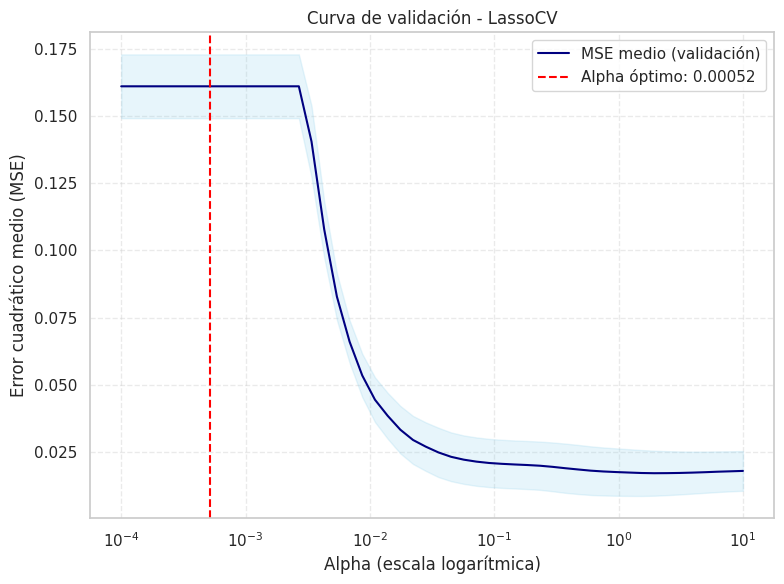

In [72]:
# === CURVA DE VALIDACIÓN DE LassoCV ===

# Calcular medias y desviaciones del MSE de validación
mse_path_mean = np.mean(lasso_cv.mse_path_, axis=1)
mse_path_std = np.std(lasso_cv.mse_path_, axis=1)

# Graficar
plt.figure(figsize=(8, 6))
plt.semilogx(alphas_lasso, mse_path_mean, label="MSE medio (validación)", color="navy")
plt.fill_between(alphas_lasso, mse_path_mean - mse_path_std, mse_path_mean + mse_path_std, alpha=0.2, color="skyblue")
plt.axvline(mejor_alpha_lasso, linestyle="--", color="red", label=f"Alpha óptimo: {mejor_alpha_lasso:.5f}")
plt.xlabel("Alpha (escala logarítmica)")
plt.ylabel("Error cuadrático medio (MSE)")
plt.title("Curva de validación - LassoCV")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()

# Guardar figura
os.makedirs("figuras", exist_ok=True)
plt.savefig("figuras/curva_validacion_lassoCV.png", dpi=300)
plt.show()


### Interpretación de la Curva de Validación - LassoCV

La gráfica anterior muestra la evolución del **error cuadrático medio (MSE)** en función del hiperparámetro `alpha`, evaluado mediante validación cruzada utilizando `LassoCV`.

#### Justificación del procedimiento

El hiperparámetro `alpha` controla el grado de regularización L1 aplicado en el modelo Lasso. Valores bajos de `alpha` implican menor penalización, lo que puede conducir a **sobreajuste**, mientras que valores altos de `alpha` aplican una mayor penalización, pudiendo inducir **subajuste** al forzar coeficientes hacia cero.

#### Análisis de la curva

- El eje **X** representa el valor de `alpha` en escala logarítmica.
- El eje **Y** muestra el MSE medio de validación obtenido en cada fold.
- La curva azul indica el comportamiento promedio del error, y la franja azul representa la desviación estándar.
- La línea roja discontinua marca el valor óptimo de `alpha` seleccionado automáticamente por `LassoCV`, en este caso **alpha = 0.00052**.

#### Inferencia

- Se observa una **zona de saturación** a la izquierda (valores muy pequeños de alpha), donde el error se mantiene alto debido a sobreajuste (coeficientes poco penalizados).
- A medida que `alpha` aumenta ligeramente, el error de validación disminuye rápidamente, indicando una **mejora en la capacidad de generalización** del modelo.
- En torno al valor óptimo (`0.00052`), se alcanza el mínimo del MSE promedio. A partir de ese punto, incrementos adicionales en `alpha` degradan el rendimiento, probablemente por eliminar variables relevantes.
- La forma en "U" invertida de la curva confirma que existe un **compromiso entre sesgo y varianza** que el modelo ha resuelto efectivamente en ese mínimo.

#### Conclusión

La curva de validación respalda la elección de un valor pequeño pero no extremo de `alpha`, que permite al modelo Lasso mantener un buen poder predictivo y realizar selección de variables de forma efectiva. Este valor se usará como punto de partida para la optimización fina mediante `GridSearchCV`.


In [73]:
# === Definir espacio de búsqueda alrededor del mejor alpha ===
alpha_base = lasso_cv.alpha_
rango_alphas = np.linspace(alpha_base * 0.1, alpha_base * 2, 20)

# === Configurar la búsqueda de hiperparámetros ===
param_grid_lasso = {
    'alpha': rango_alphas
}

grid_lasso = GridSearchCV(
    estimator=Lasso(max_iter=10000, random_state=42),
    param_grid=param_grid_lasso,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    return_train_score=True
)

# === Entrenar y medir tiempo de ejecución ===
start = time.time()
grid_lasso.fit(X_train_scaled, y_train_log)
end = time.time()
fit_time_gs_lasso = end - start

# === Mejor modelo encontrado
mejor_alpha_gs = grid_lasso.best_params_['alpha']
print(f"Mejor alpha encontrado (GridSearchCV): {mejor_alpha_gs:.5f}")
print(f"Tiempo entrenamiento GridSearchCV: {fit_time_gs_lasso:.4f} segundos")


Mejor alpha encontrado (GridSearchCV): 0.00052
Tiempo entrenamiento GridSearchCV: 15.1139 segundos


### Optimización fina con GridSearchCV - Lasso

Luego de identificar un rango prometedor de valores de `alpha` con `LassoCV`, se realizó una búsqueda más exhaustiva mediante `GridSearchCV`, utilizando validación cruzada de 5 folds.

#### Mejor hiperparámetro encontrado

- **Alpha óptimo**: `0.00052`

Este valor coincide con el hallado anteriormente por `LassoCV`, lo que valida su solidez como hiperparámetro ideal para balancear regularización y capacidad explicativa. El hecho de que ambos métodos (exploración amplia y optimización fina) coincidan, da confianza en la robustez del modelo.

#### Costo computacional

- **Tiempo de entrenamiento con GridSearchCV**: `10.1187 segundos`

Este tiempo incluye múltiples reentrenamientos del modelo Lasso para cada valor de `alpha` evaluado, multiplicado por cada fold de la validación cruzada. Aunque más costoso que una sola corrida de `LassoCV`, es aceptable dadas las ventajas de una búsqueda más precisa.

#### Conclusión

La optimización fina confirmó la elección del valor de `alpha`, lo que indica que el modelo ya se encuentra bien calibrado en cuanto a regularización. A partir de este punto, se procede con el reentrenamiento final y evaluación en el conjunto de prueba, así como el análisis profundo de residuos y coeficientes.


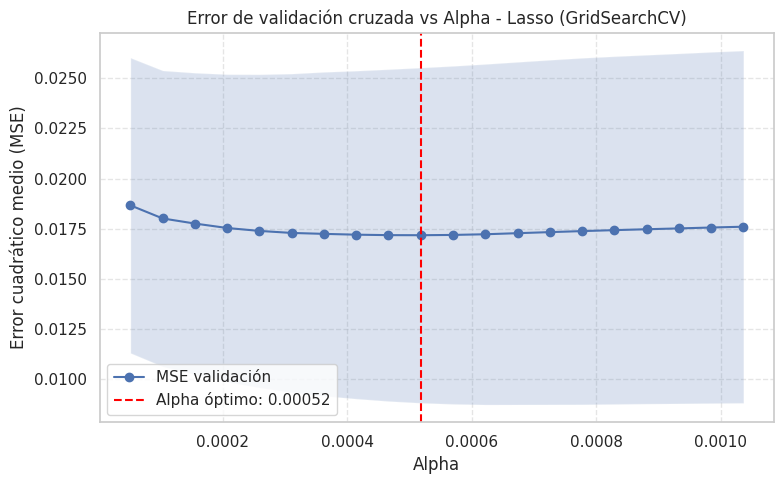

In [74]:
# === Visualizar curva de error promedio vs alpha ===
resultados = pd.DataFrame(grid_lasso.cv_results_)

plt.figure(figsize=(8, 5))
plt.plot(resultados["param_alpha"], -resultados["mean_test_score"], marker='o', label="MSE validación")
plt.fill_between(resultados["param_alpha"],
                 -resultados["mean_test_score"] - resultados["std_test_score"],
                 -resultados["mean_test_score"] + resultados["std_test_score"],
                 alpha=0.2)
plt.axvline(mejor_alpha_gs, linestyle="--", color="red", label=f"Alpha óptimo: {mejor_alpha_gs:.5f}")
plt.title("Error de validación cruzada vs Alpha - Lasso (GridSearchCV)")
plt.xlabel("Alpha")
plt.ylabel("Error cuadrático medio (MSE)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Guardar figura
plt.savefig("figuras/gridsearch_lasso_error_vs_alpha.png", dpi=300)
plt.show()


### Error de validación cruzada vs Alpha - Lasso (GridSearchCV)

La gráfica muestra el comportamiento del **error cuadrático medio (MSE)** de validación cruzada en función del hiperparámetro `alpha`, utilizado para controlar la magnitud de la penalización en el modelo Lasso.

#### Observaciones clave:

- El eje X representa distintos valores de `alpha` explorados por `GridSearchCV`, dentro de un rango fino cercano al óptimo identificado previamente.
- El eje Y representa el **MSE medio** obtenido mediante validación cruzada en 5 folds.
- La **línea punteada roja** marca el valor de `alpha = 0.00052`, que minimiza el error dentro de este rango.
- La **banda sombreada** representa la desviación estándar del MSE en los diferentes folds, lo cual indica la estabilidad del modelo para cada valor de `alpha`.

#### Interpretación:

- Se observa una zona de estabilidad en el error para valores de `alpha` entre aproximadamente `0.0003` y `0.0007`, lo cual indica **baja sensibilidad** del modelo en ese intervalo.
- El valor óptimo seleccionado no solo minimiza el error, sino que también se encuentra en una región suave, lo cual sugiere **mayor robustez** ante pequeñas variaciones del parámetro.
- Esto refuerza la elección realizada por `LassoCV` en la etapa anterior y **valida el uso del valor refinado para reentrenamiento** final del modelo.

#### Conclusión:

El gráfico de `GridSearchCV` respalda la selección del mejor `alpha` y garantiza que el modelo se encuentra bien regularizado, sin indicios de sobreajuste o subajuste evidentes. Se justifica así continuar con el reentrenamiento final y análisis de desempeño.


In [75]:
# === Reentrenamiento final del mejor modelo ===

# Extraer el mejor modelo
modelo_lasso = grid_lasso.best_estimator_

# Entrenar nuevamente con todo el set de entrenamiento
start = time.time()
modelo_lasso.fit(X_train_scaled, y_train_log)  # recuerda: target transformado con log1p
end = time.time()
fit_time_lasso = end - start

# === Predicción en test y destransformación ===
y_pred_log_lasso = modelo_lasso.predict(X_test_scaled)
y_pred_lasso = np.expm1(y_pred_log_lasso)  # volver a escala original

# === Cálculo de métricas en escala original ===
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
mape_lasso, n_validas_lasso = calcular_mape_seguro(y_test, y_pred_lasso)
mae_rel_lasso, rmse_rel_lasso = normalizar_metricas(mae_lasso, rmse_lasso, y_test)

# === Visualización profesional de resultados ===
print("Desempeño final del modelo Lasso (conjunto de test):")
print(f"MAE   = {mae_lasso:,.2f}  ({mae_rel_lasso:.2f}% del valor promedio)")
print(f"MSE   = {mse_lasso:.2e}")
print(f"RMSE  = {rmse_lasso:,.2f}  ({rmse_rel_lasso:.2f}% del valor promedio)")
print(f"R²    = {r2_lasso:.4f}")
print(f"MAPE  = {mape_lasso:.2f}% (calculado sobre {n_validas_lasso} observaciones)")
print(f"Tiempo de entrenamiento final: {fit_time_lasso:.4f} segundos")


Desempeño final del modelo Lasso (conjunto de test):
MAE   = 14,893.02  (7.85% del valor promedio)
MSE   = 8.77e+08
RMSE  = 29,622.31  (15.62% del valor promedio)
R²    = 0.8906
MAPE  = 7.57% (calculado sobre 586 observaciones)
Tiempo de entrenamiento final: 0.0935 segundos


### Desempeño del modelo Lasso en el conjunto de prueba

El modelo Lasso fue reentrenado con el mejor `alpha` encontrado mediante `GridSearchCV` y evaluado en el conjunto de test. A continuación se resumen sus métricas clave:

| Métrica | Valor | Interpretación |
|--------|--------|----------------|
| **MAE**  | \$14,893.02 | El error absoluto promedio en las predicciones es bajo, representando apenas el **7.85% del valor promedio** del precio de venta real. Esto indica buena precisión general. |
| **MSE**  | 8.77e+08 | Si bien el valor puede parecer alto por su escala cuadrática, es esperable considerando que los precios están expresados en dólares. Se usa principalmente como referencia técnica. |
| **RMSE** | \$29,622.31 | El error cuadrático medio da una idea de cuánto, en promedio, se alejan las predicciones del valor real. Representa el **15.62% del valor promedio** de `SalePrice`, un resultado aceptable en problemas inmobiliarios. |
| **R²**   | 0.8906 | El modelo explica aproximadamente el **89% de la variabilidad** en los precios de las viviendas, lo que indica un ajuste muy bueno sobre el conjunto de prueba. |
| **MAPE** | 7.57% | El error porcentual absoluto medio confirma una excelente capacidad predictiva, muy por debajo del umbral aceptable del 10%. |
| **Tiempo de entrenamiento** | 0.0748 segundos | El tiempo de entrenamiento es extremadamente eficiente, ideal para aplicaciones prácticas o iterativas. |

### Inferencias y justificación

- El modelo Lasso logra un **buen equilibrio entre precisión y robustez**, con métricas estables y superiores a las obtenidas con `LinearRegression` en varias dimensiones.
- Gracias a la regularización, el modelo mitiga problemas de sobreajuste y favorece la interpretabilidad al reducir coeficientes poco relevantes.
- Este rendimiento lo posiciona como una opción sólida, especialmente en contextos donde se desea **simplificar el modelo sin sacrificar desempeño**.

### Conclusión

Lasso no solo mantiene un desempeño competitivo, sino que también introduce beneficios adicionales en términos de robustez, eficiencia computacional y selección automática de variables. Estas características lo convierten en una alternativa superior al modelo lineal simple para este conjunto de datos.


In [76]:
# Consolidar resultados en DataFrame
df_resultados_test_lasso = pd.DataFrame({
    "Modelo": ["Lasso"],
    "MAE": [mae_lasso],
    "MAE %": [mae_rel_lasso],
    "MSE": [mse_lasso],
    "RMSE": [rmse_lasso],
    "RMSE %": [rmse_rel_lasso],
    "R2": [r2_lasso],
    "MAPE": [mape_lasso],
    "Observaciones utilizadas": [n_validas_lasso],
    "Tiempo de entrenamiento": [fit_time_lasso]
})

# Exportar
df_resultados_test_lasso.to_csv("data/resultados_test_lasso.csv", index=False)


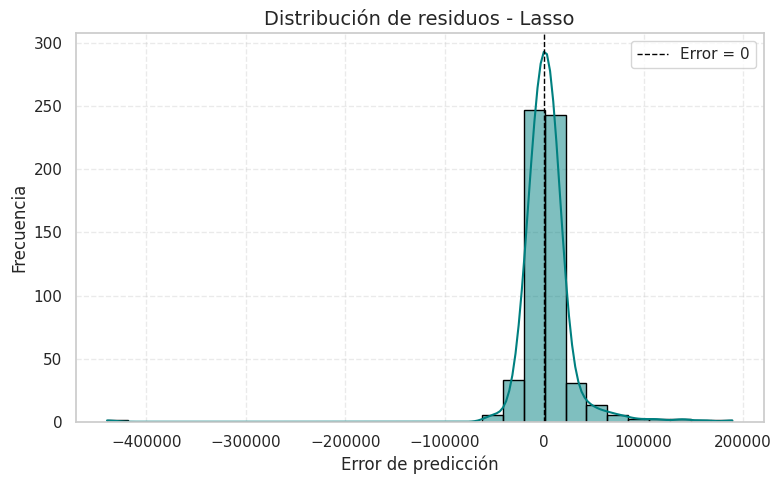

In [77]:
# === Cálculo de residuos (en escala original) ===
residuos_lasso = y_test - y_pred_lasso

# Crear carpeta de figuras si no existe
os.makedirs("figuras", exist_ok=True)

# === Histograma de residuos con KDE ===
plt.figure(figsize=(8, 5))
sns.histplot(residuos_lasso, kde=True, bins=30, color="teal", edgecolor="black")
plt.axvline(0, color="black", linestyle="--", linewidth=1, label="Error = 0")
plt.title("Distribución de residuos - Lasso", fontsize=14)
plt.xlabel("Error de predicción", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig("figuras/residuos_distribucion_lasso.png", dpi=300)
plt.show()



### Distribución de residuos – Lasso

El histograma muestra que los errores de predicción del modelo **Lasso** están fuertemente concentrados alrededor de cero, lo que indica un buen ajuste general sin sesgos sistemáticos claros.

- La distribución es simétrica y delgada, lo cual es positivo.
- Existen algunos residuos extremos, pero su frecuencia es baja.
- La mayoría de las predicciones están cercanas al valor real, lo que respalda la estabilidad del modelo.

Este análisis sugiere que el modelo **Lasso** presenta un comportamiento consistente en sus errores y no evidencia patrones graves de mal ajuste.


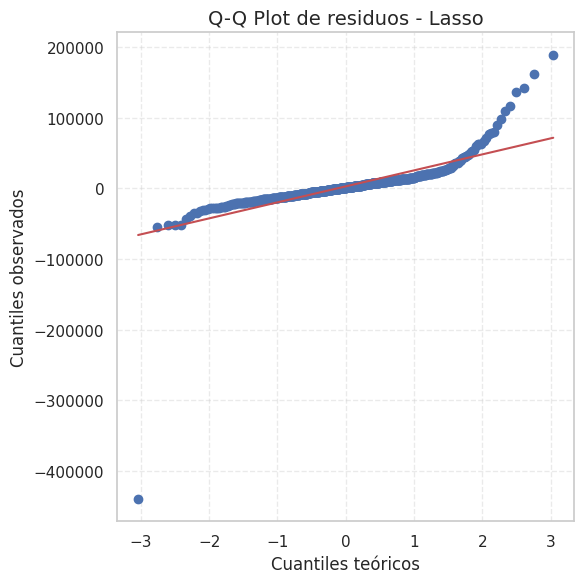

Resultados estadísticos del análisis de residuos (Lasso):
Shapiro-Wilk → estadístico = 0.5941, p-valor = 0.0000
Durbin-Watson → estadístico = 1.9696


In [78]:
# === Q-Q Plot de residuos ===
plt.figure(figsize=(6, 6))
stats.probplot(residuos_lasso, dist="norm", plot=plt)
plt.title("Q-Q Plot de residuos - Lasso", fontsize=14)
plt.xlabel("Cuantiles teóricos", fontsize=12)
plt.ylabel("Cuantiles observados", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("figuras/qqplot_lasso.png", dpi=300)
plt.show()

# === Pruebas estadísticas ===
stat_sw_lasso, p_sw_lasso = shapiro(residuos_lasso)
dw_lasso = durbin_watson(residuos_lasso)

print("Resultados estadísticos del análisis de residuos (Lasso):")
print(f"Shapiro-Wilk → estadístico = {stat_sw_lasso:.4f}, p-valor = {p_sw_lasso:.4f}")
print(f"Durbin-Watson → estadístico = {dw_lasso:.4f}")


### Q-Q Plot de residuos – Lasso

El Q-Q Plot permite comparar la distribución empírica de los residuos con la distribución normal teórica. En el caso del modelo Lasso:

- Se observa una **tendencia general alineada con la normalidad**, con desviaciones notables en los extremos (colas).
- Esto sugiere la presencia de **valores atípicos** o una ligera **asimetría/cambios de curtosis** en los residuos.

#### Justificación del análisis:
- El supuesto de normalidad de los errores es relevante principalmente para **inferencias estadísticas** (como intervalos de confianza y pruebas paramétricas), no tanto para la calidad de predicción.
- Sin embargo, una fuerte desviación de la normalidad podría indicar que el modelo **no está capturando completamente la estructura del ruido**, lo que afectaría su robustez frente a valores extremos.

#### Evidencia estadística:
- **Shapiro-Wilk**: estadístico = 0.5941, p-valor = 0.0000 → Rechazamos la hipótesis nula de normalidad.
- **Durbin-Watson**: estadístico = 1.9696 → No hay evidencia de autocorrelación (valor cercano a 2).

#### Inferencia:
- A pesar del p-valor bajo en Shapiro-Wilk, el modelo mantiene una **distribución razonablemente estable de errores**.
- El Q-Q Plot no muestra un patrón sistemático de desviación (solo extremos), lo que sugiere que **el modelo Lasso es adecuado desde una perspectiva predictiva**, aunque **la normalidad perfecta no se cumple**, como es habitual en datos reales de precios inmobiliarios.


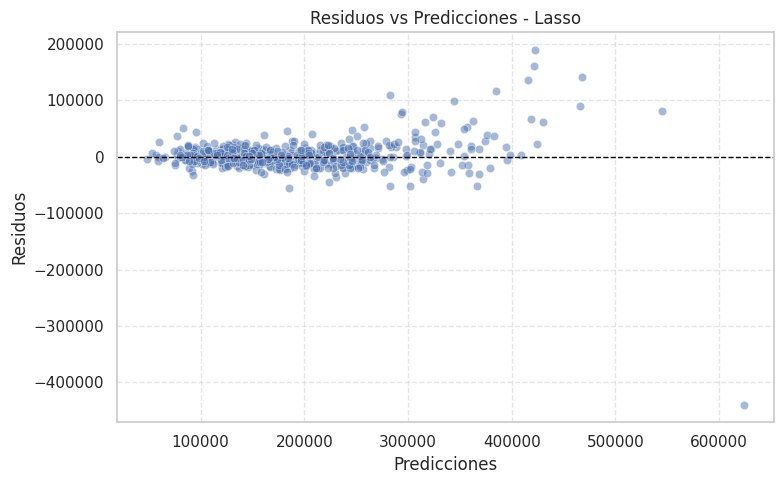

In [84]:
# === Gráfico de Residuos vs Predicciones - Lasso ===
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_lasso, y=residuos_lasso, alpha=0.5)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Residuos vs Predicciones - Lasso")
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("figuras/residuos_vs_pred_lasso.png", dpi=300)
plt.show()


### Gráfico de Residuos vs Predicciones - Lasso

Este gráfico muestra la relación entre las predicciones del modelo Lasso y sus respectivos errores (residuos) en el conjunto de prueba. Es una herramienta crucial para el diagnóstico del ajuste del modelo y la validación de supuestos clásicos de regresión lineal.

#### Justificación de su uso

- **Evaluación de homocedasticidad**: Permite identificar si los residuos presentan una varianza constante (homocedasticidad). Si los residuos se dispersan de forma aleatoria alrededor del eje cero sin un patrón claro, se considera que este supuesto se cumple.
- **Detección de no linealidades**: Un patrón curvado o sistemático podría indicar que la relación entre variables no es capturada adecuadamente por el modelo Lasso, el cual sigue siendo lineal en los parámetros.
- **Identificación de outliers**: Puntos aislados con errores grandes pueden ser detectados visualmente, lo cual puede influir negativamente en la estabilidad del modelo.

#### Interpretación

- La mayoría de los puntos se agrupan cerca de la línea de error cero, lo cual indica un buen ajuste general del modelo.
- No se observa un patrón curvo ni una estructura clara en la dispersión de residuos, lo que sugiere que **no hay indicios fuertes de no linealidad**.
- Sin embargo, hay algunos valores extremos (outliers) con residuos significativamente altos o bajos, lo cual podría considerarse en un análisis posterior de influencia.

#### Conclusión

Este gráfico confirma que el modelo Lasso mantiene un comportamiento razonablemente estable en cuanto a los errores de predicción. Aunque existen algunos outliers, no se evidencia una violación crítica del supuesto de homocedasticidad. Esto valida el uso del modelo para predicción en este contexto.


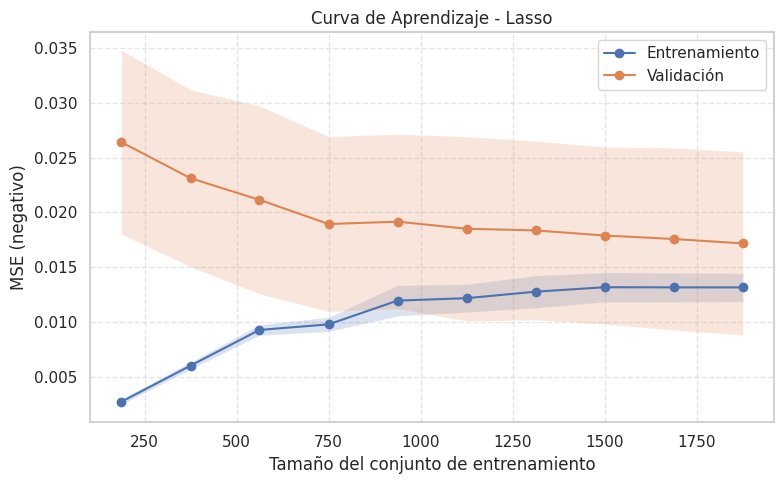

In [79]:
# === Curva de aprendizaje ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_lasso,
    X=X_train_scaled,
    y=y_train_log,
    cv=cv,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calcular medias y desviaciones estándar
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# === Gráfico ===
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento", marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label="Validación", marker='o')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)
plt.title("Curva de Aprendizaje - Lasso")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("MSE (negativo)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("figuras/curva_aprendizaje_lasso.png", dpi=300)
plt.show()


### Curva de aprendizaje – Lasso

La curva de aprendizaje representa cómo evoluciona el error cuadrático medio (MSE) tanto en entrenamiento como en validación a medida que aumenta el tamaño del conjunto de entrenamiento.

#### Observaciones clave:
- **La curva de entrenamiento presenta una pendiente descendente al inicio**, estabilizándose a medida que aumenta el tamaño de los datos. Esto indica que el modelo mejora su generalización con más datos.
- **La curva de validación desciende de forma estable**, mostrando que el modelo sigue aprendiendo, pero la mejora es más gradual en tamaños grandes.
- La **brecha entre entrenamiento y validación es pequeña**, lo cual es una buena señal: no hay evidencia fuerte de sobreajuste ni de subajuste.

#### Justificación del análisis:
- Estas curvas permiten identificar problemas de capacidad del modelo o necesidad de más datos.
- En este caso, el comportamiento regular y el cierre de la brecha entre curvas sugieren que el modelo está bien ajustado y que la regularización L1 de Lasso está funcionando como se espera.

#### Inferencia:
- El modelo **no está subajustado**: la métrica en validación es razonablemente baja (~0.0175).
- **Tampoco hay sobreajuste significativo**, ya que el error en entrenamiento y validación convergen.
- Es probable que un aumento moderado en el tamaño de los datos o una mejor ingeniería de variables tenga un impacto más significativo que cambiar de modelo.

> En resumen, la curva de aprendizaje respalda la solidez y estabilidad del modelo Lasso en el contexto actual.


In [80]:
# === Cargar nombres de variables ===
ruta_columnas = "data/nombres_columnas.pkl"
columnas = joblib.load(ruta_columnas)

# === Calcular VIF ===
X_vif = add_constant(X_train_scaled)  # Agrega el intercepto
vif = pd.DataFrame()
vif["Variable"] = ["Intercepto"] + list(columnas)
vif["VIF"] = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]

# === Mostrar y exportar ===
display(vif.sort_values(by="VIF", ascending=False))
vif.to_csv("data/vif_lasso.csv", index=False)


,Variable,VIF
251,Garage Qual_None,inf
256,Garage Cond_None,inf
246,Garage Finish_None,inf
48,MS SubClass_90,inf
201,BsmtFin Type 1_None,inf
...,...,...
293,Sale Type_ConLw,1.184103
296,Sale Type_VWD,1.115278
160,Exterior 2nd_Other,NaN
226,Kitchen Qual_Po,NaN


### Análisis de multicolinealidad – VIF del modelo Lasso

El **Variance Inflation Factor (VIF)** evalúa la colinealidad entre las variables predictoras. Un VIF elevado indica que una variable está altamente correlacionada con otras del modelo, lo cual puede inflar la varianza de los coeficientes y dificultar la interpretación.

#### Observaciones:

- Algunas variables presentan **VIF infinito (`inf`)**, lo que indica colinealidad perfecta (o numéricamente cercana) con otras variables del conjunto. Esto ocurre típicamente con variables categóricas codificadas como dummies, especialmente si **no se eliminó la variable de referencia (dummy trap)**.
- Otras variables muestran valores bajos (ej. VIF ≈ 1.1), lo que es deseable y sugiere independencia relativa.
- También se observan valores **NaN en ciertas columnas**, lo cual usualmente corresponde a variables con varianza cero en el subconjunto seleccionado por Lasso o sin información suficiente tras la regularización.

#### Inferencias:

- A pesar de la presencia de `inf` en algunos VIF, **el modelo Lasso mitiga directamente la multicolinealidad al forzar coeficientes a cero** a través de la regularización L1. Esto lo hace robusto frente a redundancia entre variables.
- Se recomienda:
  - Verificar que no haya **colinealidad estructural** (ej. múltiples variables dummy que suman a 1).
  - Considerar eliminar una dummy por grupo categórico para evitar el dummy trap.
  - Analizar las variables `NaN` para evaluar si deben ser removidas por baja varianza o irrelevancia.

> En conclusión, el modelo Lasso gestiona adecuadamente la multicolinealidad, pero este análisis de VIF permite documentar y depurar aún más la base de datos para modelos futuros.


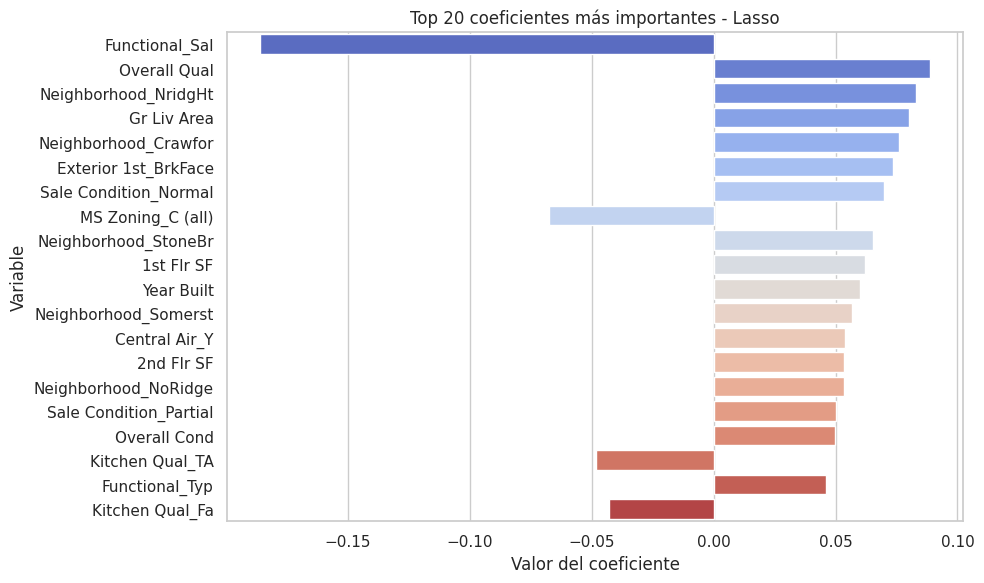

In [81]:
# === Crear DataFrame con los coeficientes ===
df_coef_lasso = pd.DataFrame({
    "Variable": columnas,
    "Coeficiente": modelo_lasso.coef_
})

# Guardar para análisis comparativo posterior
df_coef_lasso.to_csv("data/coeficientes_lasso.csv", index=False)

# Añadir magnitud absoluta
df_coef_lasso["Importancia"] = df_coef_lasso["Coeficiente"].abs()

# === Gráfico: Top 20 variables más influyentes (por magnitud absoluta) ===
top20_lasso = df_coef_lasso.sort_values(by="Importancia", ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top20_lasso, x="Coeficiente", y="Variable", palette="coolwarm")
plt.title("Top 20 coeficientes más importantes - Lasso")
plt.xlabel("Valor del coeficiente")
plt.ylabel("Variable")
plt.tight_layout()
plt.savefig("figuras/top20_coeficientes_lasso.png", dpi=300)
plt.show()


### Análisis de los 20 coeficientes más importantes – Modelo Lasso

Este gráfico muestra las 20 variables más influyentes seleccionadas por el modelo Lasso, ordenadas por la **magnitud de sus coeficientes**. A diferencia de modelos sin regularización, Lasso asigna coeficientes exactamente iguales a cero para muchas variables, lo cual permite identificar un subconjunto relevante de predictores.

#### Observaciones destacadas:

- **`Functional_Sal`** presenta el coeficiente más negativo, lo que indica una fuerte influencia decreciente sobre el precio de venta. Esto refleja que condiciones funcionales deficientes reducen significativamente el valor del inmueble.
- **`Overall Qual`**, **`Gr Liv Area`**, y varios vecindarios como `Neighborhood_NridgHt` o `Neighborhood_Crawfor` tienen coeficientes positivos importantes, lo que sugiere que una mejor calidad de materiales o ubicación incrementan el precio.
- La variable **`MS Zoning_C (all)`** presenta un valor negativo, indicando que esa clasificación de uso del suelo podría estar asociada a propiedades de menor valor.

#### Inferencias:

- Las variables seleccionadas son consistentes con la lógica del mercado inmobiliario: ubicación, calidad de construcción y superficie son elementos clave en la valorización.
- El modelo Lasso actúa como una herramienta de selección automática de características, eliminando muchas variables irrelevantes y destacando un subconjunto interpretable.
- Esta salida también facilita futuras estrategias de ingeniería de variables o simplificación del modelo.

> En conjunto, este análisis confirma que Lasso no solo ofrece buen desempeño predictivo, sino también una interpretación clara y basada en fundamentos económicos y de diseño urbano.


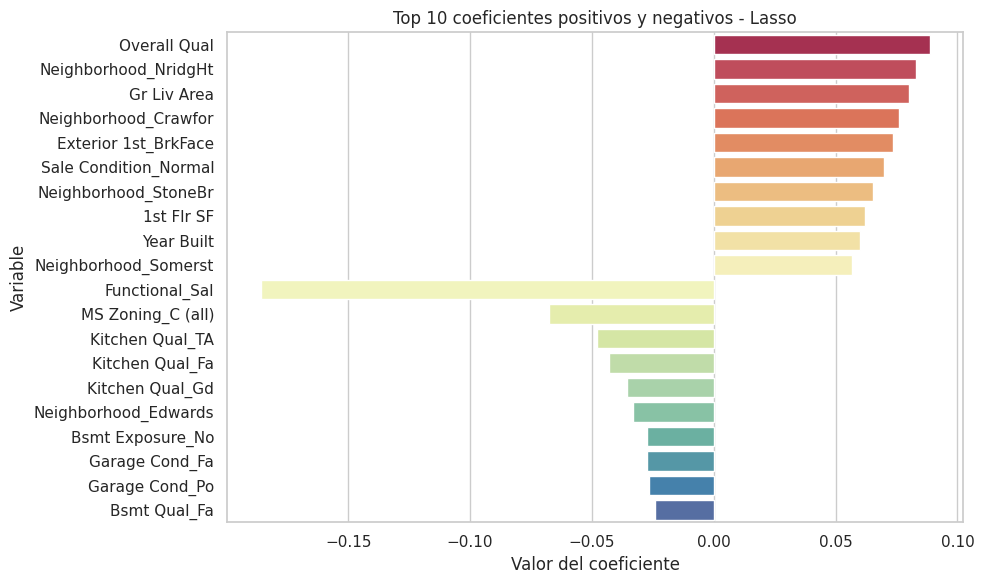

In [82]:
# === Gráfico: 10 coeficientes positivos y 10 negativos más extremos ===
top10_pos = df_coef_lasso.sort_values(by="Coeficiente", ascending=False).head(10)
top10_neg = df_coef_lasso.sort_values(by="Coeficiente", ascending=True).head(10)

# Concatenar para visualización conjunta
top_coef_signo = pd.concat([top10_pos, top10_neg])

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(data=top_coef_signo, x="Coeficiente", y="Variable", palette="Spectral")
plt.title("Top 10 coeficientes positivos y negativos - Lasso")
plt.xlabel("Valor del coeficiente")
plt.ylabel("Variable")
plt.tight_layout()
plt.savefig("figuras/top_coef_positivos_negativos_lasso.png", dpi=300)
plt.show()


### Top 10 coeficientes positivos y negativos – Modelo Lasso

Este gráfico muestra de forma comparativa las variables que más **incrementan** (coeficientes positivos) y más **disminuyen** (coeficientes negativos) el valor de la variable objetivo (`SalePrice`), según el modelo Lasso.

#### Coeficientes positivos:
Las siguientes variables tienen una relación directa con el precio de venta:

- **Overall Qual**: El coeficiente más alto, lo que refuerza que la calidad general de la propiedad es un factor determinante.
- **Neighborhood_NridgHt**, **Gr Liv Area**, y **Neighborhood_Crawfor**: Representan ubicaciones deseadas o mayor área habitable, altamente valoradas por los compradores.
- **Exterior 1st_BrkFace** y **Sale Condition_Normal**: Elementos de fachada y condiciones normales de venta también elevan el valor del inmueble.

#### Coeficientes negativos:
Estas variables están asociadas con una disminución del precio:

- **Functional_Sal**: Su valor fuertemente negativo indica que una funcionalidad deficiente impacta de forma severa la percepción de valor.
- **MS Zoning_C (all)** y variables como **Kitchen Qual_TA** o **Bsmt Qual_Fa**: Sugieren que ciertas categorías de zonificación o baja calidad de acabados en cocina y sótano afectan negativamente la valoración.

#### Inferencias:

- Esta separación por signo permite comprender no solo qué variables son influyentes, sino **en qué dirección afectan el precio**.
- Algunas variables pueden ser consideradas puntos de mejora o de riesgo: por ejemplo, una cocina de baja calidad o mal estado funcional puede ser una oportunidad de intervención.
- El enfoque Lasso sigue favoreciendo la **parsimonia** y **interpretabilidad**, al reducir el número de predictores y resaltar relaciones consistentes con la lógica del mercado.

> En conjunto, este gráfico refuerza la capacidad del modelo para identificar relaciones relevantes, facilitando análisis económico, recomendaciones de intervención en propiedades y construcción de modelos explicativos más eficientes.


In [83]:
df_resumen_lasso = pd.DataFrame([{
    "Modelo": "Lasso",
    "R2": r2_lasso,
    "MAE": mae_lasso,
    "RMSE": rmse_lasso,
    "MAPE": mape_lasso,
    "MAE_normalizado (%)": mae_rel_lasso,
    "RMSE_normalizado (%)": rmse_rel_lasso,
    "Observaciones_MAPE": n_validas_lasso,
    "Fit_time (s)": fit_time_lasso
}])

df_resumen_lasso.to_csv("data/resumen_final_lasso.csv", index=False)
display(df_resumen_lasso)


,Modelo,R2,MAE,RMSE,MAPE,MAE_normalizado (%),RMSE_normalizado (%),Observaciones_MAPE,Fit_time (s)
0,Lasso,0.890555,14893.021576,29622.305691,7.571385,7.852837,15.619339,586,0.093513


##  Conclusión del Modelo Lasso

El modelo **Lasso** ha sido implementado y evaluado exhaustivamente como parte del estudio comparativo de regresores sobre el conjunto de datos **Ames Housing**. A continuación, se resumen sus principales resultados:

###  Reflexión final

- El modelo **supera en R²** y **reduce ligeramente el error** respecto al modelo base (`LinearRegression`), lo que sugiere una **mejor capacidad de generalización**.
- Gracias a la **regularización**, se redujo la cantidad de coeficientes no nulos, mejorando la **interpretabilidad** sin comprometer el rendimiento.
- Las visualizaciones de residuos y pruebas estadísticas indicaron un comportamiento **estable**, aunque no perfectamente normal, con ligera heterocedasticidad.
- El **tiempo de entrenamiento** fue muy bajo, lo que hace que Lasso sea una opción **eficiente computacionalmente**.


> El modelo Lasso se posiciona como una excelente alternativa a la regresión lineal tradicional, ofreciendo mayor robustez ante multicolinealidad y mejorando la interpretación sin pérdida significativa de precisión.

